In [1]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import easygems.healpix as egh
import cartopy.crs as ccrs
import healpy as hp
import numpy as np
import pandas as pd

In [2]:
def get_nn_lon_lat_index(nside, lons, lats):
    """
    nside: integer, power of 2. The return of hp.get_nside()
    lons: uniques values of longitudes
    lats: uniques values of latitudes
    returns: array with the HEALPix cells that are closest to the lon/lat grid
    """
    lons2, lats2 = np.meshgrid(lons, lats)
    return xr.DataArray(
        hp.ang2pix(nside, lons2, lats2, nest = True, lonlat = True),
        coords=[('latitude', lats), ('longitude', lons)],
    )

In [3]:
zarr_file = "/g/data/qx55/germany_node/d3hp003.zarr/PT1H_point_z10_atm.zarr"
ds = xr.open_zarr(zarr_file)

In [4]:
var_um = ds['pr']

In [17]:
# Find the HEALPix pixels that are closest to the ERA5 grid
res = 0.04
# longitudes and latitudes for the ERA5 grid
lon = np.arange(130.5,131.5+res,res)
lat = np.arange(-13, -12+res,res)

# nside for um simulation, it should be equal to 2**zoom
this_nside = hp.get_nside(var_um)

cells = get_nn_lon_lat_index(this_nside, lon, lat) 

var_um_regrided = var_um.isel(cell = cells)#.rename({'lon': 'longitude', 'lat': 'latitude'}) # regriding


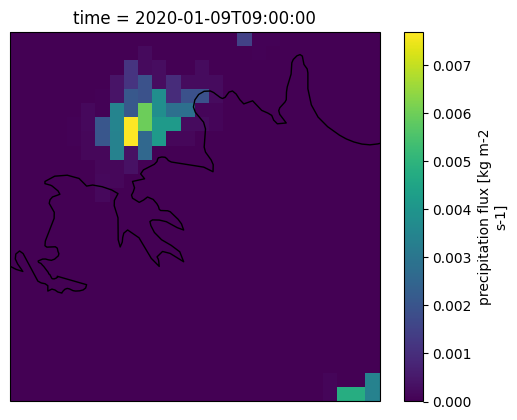

In [9]:
projection = ccrs.PlateCarree(central_longitude = 0.0)
fig, ax = plt.subplots(subplot_kw = {"projection": projection})
var_um_regrided.isel(time = 200).plot(cmap = 'viridis', transform = ccrs.PlateCarree())
ax.coastlines()

In [7]:

# Create full date range from 2020-03-01 to 2021-02-28
full_range = pd.date_range(start="2020-03-01", end="2021-02-28", freq="h")

# Define exclusion period
exclude_start = pd.Timestamp("2020-05-01 00:00:00")
exclude_end = pd.Timestamp("2020-09-30 00:00:00")

# Filter out the excluded range
filtered_range = full_range[(full_range < exclude_start) | (full_range > exclude_end)]

# Convert to list of strings in yyyymmdd format
date_str_list = filtered_range.strftime("%Y%m%d %H:%M:%S").tolist()

In [18]:
var_um_regrided.attrs.pop("hiopy::time_method", None)
var_um_regrided.attrs.pop("hiopy::nnn",         None)
var_um_regrided.attrs.pop("hiopy::enable",      None)

True

In [19]:
var_um_regrided

<xarray.DataArray 'pr' (time: 10200, latitude: 26, longitude: 26)> Size: 28MB
dask.array<transpose, shape=(10200, 26, 26), dtype=float32, chunksize=(4, 26, 26), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 82kB 2020-01-01T01:00:00 ... 2021-03-01
  * latitude   (latitude) float64 208B -13.0 -12.96 -12.92 ... -12.04 -12.0
  * longitude  (longitude) float64 208B 130.5 130.5 130.6 ... 131.4 131.5 131.5
Attributes:
    grid_mapping:   crs
    standard_name:  pr
    units:          kg m-2 s-1
    short_name:     
    long_name:      precipitation flux

In [20]:
%%time
var_um_regrided.sel(time=date_str_list).to_netcdf("/scratch/nf33/hk25_LSP/Germany/Darwin/pr_hourly.nc")

CPU times: user 9.36 s, sys: 9.98 s, total: 19.3 s
Wall time: 7.95 s
